## Causal Impact Analysis of Media Campaign on Sales
### Bayesian structure time series modeling (BSTS) using pymc


This notebook illustrates the causal impact analysis of a media campaign on sales using Bayesian Structural Time Series (BSTS) with the pymc_experimental.statespace module. A significant positive causal impact of the media campaign was identified in the post-intervention period. Using PyMC provides full control over priors, such as half-normal priors for external predictors, ensuring that coefficient estimates for some covariates such as media spend are positive. Building such a model with PyMC is more flexible but generally requires more effort compared to using other libraries like Pybuc.

In [44]:
#!pip install pymc_experimental

In [43]:
#!pip install scipy==1.12.0

In [45]:
#!pip install patsy

In [1]:
import pymc_experimental as pmx

In [4]:
import jax

jax.config.update("jax_platform_name", "cpu")
import numpyro

numpyro.set_host_device_count(8)

import sys

sys.path.append("..")
from pymc_experimental.statespace import structural as st
from pymc_experimental.statespace.utils.constants import SHORT_NAME_TO_LONG, MATRIX_NAMES
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
import numpy as np
import pandas as pd
from patsy import dmatrix

### Generate sales and media spend data

In [65]:
import numpy as np
import pandas as pd

np.random.seed(123)

# Function to create media spend pattern
def create_media_spend_pattern(n_days, min_on=10, max_on=30, min_off=30, max_off=90, spend_range=(100, 300)):
    pattern = np.zeros(n_days)
    current_day = 0
    while current_day < n_days:
        on_period = np.random.randint(min_on, max_on)
        off_period = np.random.randint(min_off, max_off)
        end_on_period = min(current_day + on_period, n_days)
        pattern[current_day:end_on_period] = np.random.uniform(spend_range[0], spend_range[1], end_on_period - current_day)
        current_day = end_on_period + off_period
    return pattern

# Function to create sales data with similar pattern
def create_sales_data(start_date, end_date):
    # Create dates range
    timestamps = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(timestamps)

    # Create a DataFrame
    df = pd.DataFrame({
        'Date': timestamps,
        'Sales': np.zeros(n_days),
        'Media_YouTube': np.zeros(n_days),
        'Media_Amazon': np.zeros(n_days),
        'Media_TikTok': np.zeros(n_days)
    })

    # Define sales patterns for each phase
    intro_growth = np.linspace(10, 100, num=int(n_days*1/6))
    growth = np.linspace(100, 1000 + np.random.randint(0, 200), num=int(n_days*1/3))
    maturity = np.linspace(1000 + np.random.randint(0, 200), 900, num=int(n_days*1/6))
    decline = np.linspace(900, 500, num=n_days - len(intro_growth) - len(growth) - len(maturity))

    # Combine the sales patterns
    sales = np.concatenate([intro_growth, growth, maturity, decline])

    # Apply the sales pattern to the DataFrame
    df['Sales'] = sales

    # Generate media spend patterns for each channel
    df['Media_YouTube'] = create_media_spend_pattern(n_days)
    df['Media_Amazon'] = create_media_spend_pattern(n_days)
    df['Media_TikTok'] = create_media_spend_pattern(n_days)

    # Increase sales when media is on
    media_active_index = (df['Media_YouTube'] > 0) | (df['Media_Amazon'] > 0) | (df['Media_TikTok'] > 0)
    df.loc[media_active_index, 'Sales'] *= 1.1  # Increase by 10% when any media is active

    # Add slight day-to-day sales variability
    df['Sales'] += np.random.normal(0, 50, size=n_days)
    df['Sales'] = df['Sales'].clip(lower=0)

    # Create an index to apply holiday effects
    holiday_index = df['Date'].apply(lambda x: x.month in [12, 1, 7] and x.day in [1, 4, 23, 30])

    # Increase sales on holidays by a factor (e.g., 1.2)
    df.loc[holiday_index, 'Sales'] *= 1.2

    # Round sales to integer values
    df['Sales'] = df['Sales'].round(0).astype(int)
    df['Holiday'] = np.where(holiday_index, 1, 0)

    return df

# Generate 2022 data
df_2022 = create_sales_data(start_date='2022-01-01', end_date='2022-12-31')

# Generate 2023 data with similar pattern
df_2023 = create_sales_data(start_date='2023-01-01', end_date='2023-12-31')

# Concatenate both dataframes
df_all = pd.concat([df_2022, df_2023]).reset_index(drop=True)

df_all.head()

,Date,Sales,Media_YouTube,Media_Amazon,Media_TikTok,Holiday
0,2022-01-01,0,238.176971,204.231886,163.028605,1
1,2022-01-02,48,243.830062,216.126404,198.302128,0
2,2022-01-03,0,198.223787,161.839800,264.028408,0
3,2022-01-04,68,256.005552,283.976525,126.524091,1
4,2022-01-05,0,182.184875,231.069501,124.261896,0


In [88]:
df_all[df_all.Date>'2023-09-01']

,Date,Sales,Media_YouTube,Media_Amazon,Media_TikTok,Holiday
609,2023-09-02,1031,103.144003,0.000000,273.706772,0
610,2023-09-03,1008,275.132656,0.000000,132.999601,0
611,2023-09-04,929,182.010901,0.000000,137.064382,0
612,2023-09-05,1056,272.413728,0.000000,236.037228,0
613,2023-09-06,912,128.666083,0.000000,115.656049,0
...,...,...,...,...,...,...
725,2023-12-27,512,0.000000,173.792126,0.000000,0
726,2023-12-28,538,0.000000,155.631872,0.000000,0
727,2023-12-29,669,0.000000,210.803095,0.000000,0
728,2023-12-30,722,0.000000,162.852223,0.000000,1


### Generate campaign effect

In [67]:
df=df_all.copy()
campaign_start = pd.Timestamp('2023-09-01')
campaign_end = pd.Timestamp('2023-11-30')

campaign_index = df['Date'].between(campaign_start, campaign_end)
df.loc[campaign_index, 'Sales'] *= 1.3
df.loc[campaign_index, 'Sales'] = df.loc[campaign_index, 'Sales'].round(0).astype(int)

df.index=df.Date
df.drop('Date', axis=1,inplace=True)

/var/folders/m8/8x18gbj154n8f2pcjn2xp2yr0000gn/T/ipykernel_48520/618463762.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1374.1 1340.3 1310.4 1207.7 1372.8 1185.6 1268.8 1276.6 1293.5 1302.6
 1233.7 1192.1 1190.8 1307.8 1188.2 1272.7 1105.  1402.7 1171.3 1128.4
 1339.  1071.2 1205.1 1064.7 1132.3 1181.7  993.2 1003.6 1045.2 1040.
 1158.3  960.7 1128.4  950.3  943.8 1047.8  971.1  867.1 1008.8 1132.3
  952.9  981.5 1014.   955.5  897.  1002.3  932.1  988.  1107.6 1194.7
 1116.7 1045.2 1038.7 1033.5  972.4 1123.2 1025.7  981.5  977.6 1050.4
  956.8  939.9 1016.6  816.4  906.1  813.8 1003.6  973.7  920.4  833.3
  838.5  908.7  933.4  812.5  786.5  825.5  850.2  786.5  794.3  768.3
  794.3  835.9  908.7  825.5  759.2  724.1  764.4  712.4  848.9  850.2
  852.8]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[campaign_index, 'Sales'] *= 1.3


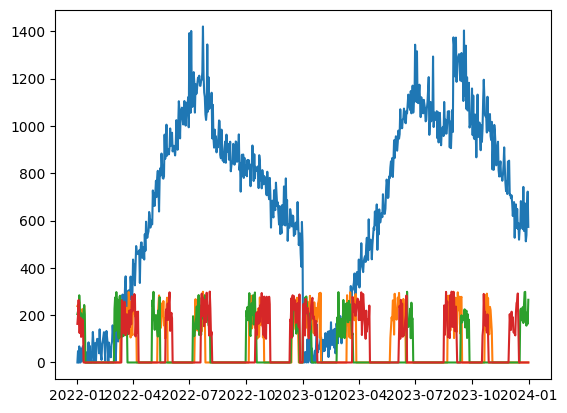

In [68]:
plt.plot(df['Sales'])
plt.plot(df['Media_YouTube'])
plt.plot(df['Media_Amazon'])
plt.plot(df['Media_TikTok'])
plt.show()

### Generate pre- and post- internvetion data for modeling

In [69]:
pre_period_df=df[df.index<campaign_start]
post_period_df=df[df.index>=campaign_start]

In [70]:
post_period_df

,Sales,Media_YouTube,Media_Amazon,Media_TikTok,Holiday
Date,,,,,
2023-09-01,1374.0,298.919746,0.000000,298.360927,0
2023-09-02,1340.0,103.144003,0.000000,273.706772,0
2023-09-03,1310.0,275.132656,0.000000,132.999601,0
2023-09-04,1208.0,182.010901,0.000000,137.064382,0
2023-09-05,1373.0,272.413728,0.000000,236.037228,0
...,...,...,...,...,...
2023-12-27,512.0,0.000000,173.792126,0.000000,0
2023-12-28,538.0,0.000000,155.631872,0.000000,0
2023-12-29,669.0,0.000000,210.803095,0.000000,0


### Build state space model

In [28]:
mod = st.LevelTrendComponent(order=2, innovations_order=[0, 1])
mod += st.AutoregressiveComponent(order=1)
mod += st.MeasurementError(name="obs")
mod+=st.RegressionComponent(name="exog", k_exog=4, innovations=False)
ss_mod = mod.build(name="sales")

The following parameters should be assigned priors inside a PyMC model block: 
	initial_trend -- shape: (2,), constraints: None, dims: ('trend_state',)
	sigma_trend -- shape: (1,), constraints: Positive, dims: ('trend_shock',)
	ar_params -- shape: (1,), constraints: None, dims: ('ar_lag',)
	sigma_ar -- shape: (1,), constraints: Positive, dims: None
	sigma_obs -- shape: (1,), constraints: Positive, dims: ('observed_state',)
	beta_exog -- shape: (1,), constraints: None, dims: ('exog_state',)
	P0 -- shape: (7, 7), constraints: Positive semi-definite, dims: ('state', 'state_aux')
The following MutableData variables should be assigned to the model inside a PyMC model block: 
	data_exog -- shape: (None, 4), dims: ('time', 'exog_state')


In [29]:
ss_mod.param_dims.values()


dict_values([('trend_state',), ('trend_shock',), ('ar_lag',), ('observed_state',), ('exog_state',), ('state', 'state_aux')])

In [30]:
initial_trend_dims, sigma_trend_dims, ar_param_dims,sigma_obs_dims, beta_exog_dims,P0_dims = ss_mod.param_dims.values()
coords = ss_mod.coords

In [31]:
coords

{'trend_state': ['level', 'trend'],
 'trend_shock': ['trend'],
 'ar_lag': [1],
 'exog_state': ['exog_1', 'exog_2', 'exog_3', 'exog_4'],
 'state': ['level',
  'trend',
  'L1.data',
  'exog_1',
  'exog_2',
  'exog_3',
  'exog_4'],
 'state_aux': ['level',
  'trend',
  'L1.data',
  'exog_1',
  'exog_2',
  'exog_3',
  'exog_4'],
 'observed_state': ['sales'],
 'observed_state_aux': ['sales'],
 'shock': ['trend',
  'AutoRegressive_innovation',
  'exog_1',
  'exog_2',
  'exog_3',
  'exog_4'],
 'shock_aux': ['trend',
  'AutoRegressive_innovation',
  'exog_1',
  'exog_2',
  'exog_3',
  'exog_4']}

In [15]:
P0_dims

('state', 'state_aux')

In [32]:
coords_mutable = {'obs': np.arange(len(pre_period_df))}

### Train the model with pymc on pre intervention data

In [34]:
# Define the PyMC model
with pm.Model(coords=coords,coords_mutable=coords_mutable) as model:
    # Priors for the parameters
    #obs_data = pm.MutableData("obs_data", pre_period_df['Sales'], dims=('obs','observed_state'))
    obs_data=pre_period_df['Sales']
    exog_data=pre_period_df[['Media_YouTube','Media_Amazon','Media_TikTok',	'Holiday']]

    initial_trend = pm.Normal("initial_trend", mu=0, sigma=1, dims=initial_trend_dims)
    sigma_trend = pm.HalfNormal("sigma_trend", sigma=1, dims=sigma_trend_dims)
    ar_params = pm.Normal("ar_params", mu=0, sigma=1, dims=ar_param_dims)
    sigma_ar = pm.HalfNormal("sigma_ar", sigma=1,shape=(1,))
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=1)
    beta_exog = pm.HalfNormal("beta_exog",  sigma=1, dims=beta_exog_dims)

    # Constraint for P0 to be positive semi-definite
    P0_diag = pm.Gamma("P0_diag", alpha=5, beta=5)
    P0 = pm.Deterministic("P0", np.eye(ss_mod.k_states) * P0_diag, dims=P0_dims)

    # Mutable data variables
    data_exog = pm.MutableData("data_exog",  exog_data,dims=('obs','exog_state'))

# To fit the model, you would then proceed with model fitting steps such as sampling.

    ss_mod.build_statespace_graph( obs_data, mode="JAX")

    idata = pm.sample(nuts_sampler="numpyro", chains=8, draws=500)

/opt/anaconda3/envs/myenv_39/lib/python3.9/site-packages/pymc_experimental/statespace/utils/data_tools.py:96: UserWarning: No frequency was specific on the data's DateTimeIndex.
  warnings.warn(NO_FREQ_INFO_WARNING)


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'initial_trend'}>,
        <Axes: title={'center': 'initial_trend'}>],
       [<Axes: title={'center': 'ar_params'}>,
        <Axes: title={'center': 'ar_params'}>],
       [<Axes: title={'center': 'sigma_trend'}>,
        <Axes: title={'center': 'sigma_trend'}>],
       [<Axes: title={'center': 'sigma_ar'}>,
        <Axes: title={'center': 'sigma_ar'}>],
       [<Axes: title={'center': 'sigma_obs'}>,
        <Axes: title={'center': 'sigma_obs'}>],
       [<Axes: title={'center': 'beta_exog'}>,
        <Axes: title={'center': 'beta_exog'}>],
       [<Axes: title={'center': 'P0_diag'}>,
        <Axes: title={'center': 'P0_diag'}>]], dtype=object)

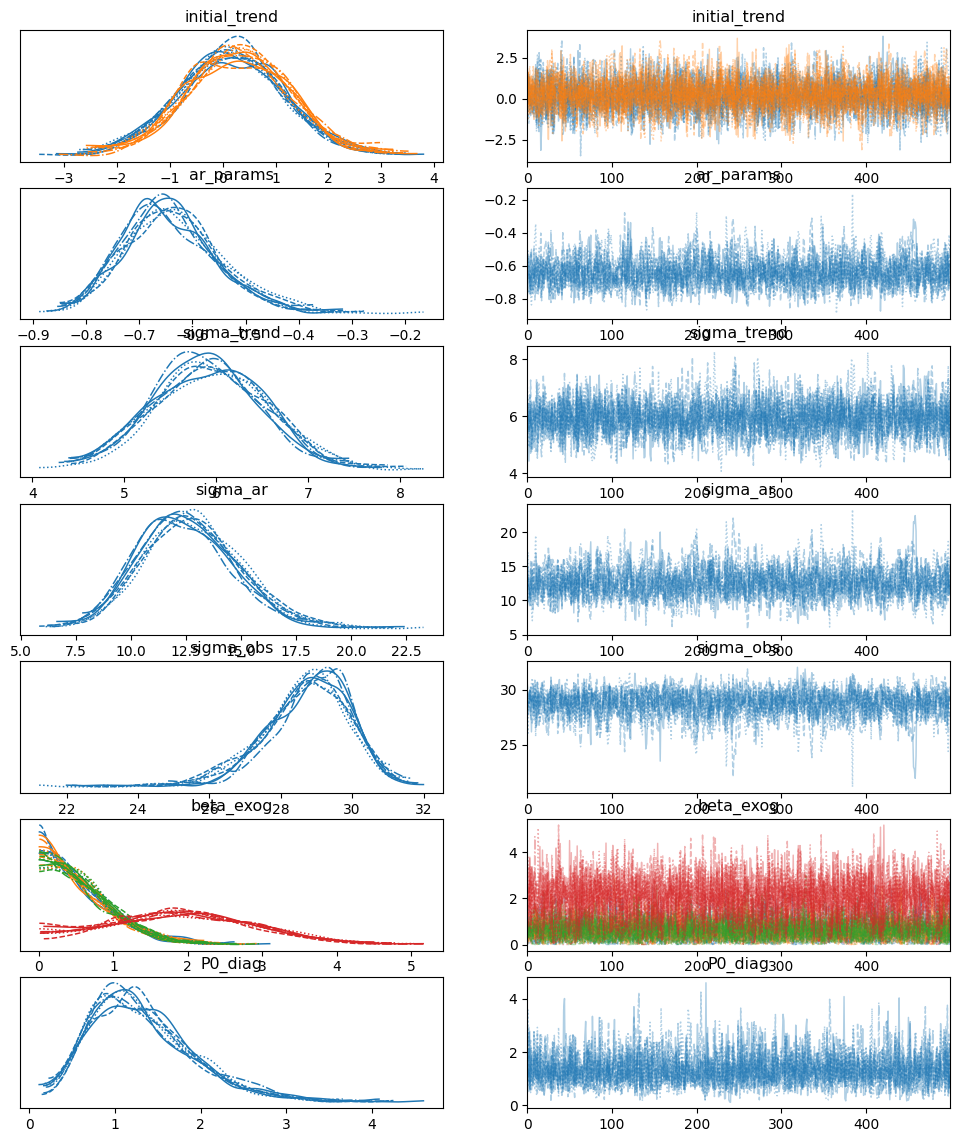

In [35]:
az.plot_trace(idata, var_names=["~P0"])

In [86]:
#post_pred = ss_mod.sample_conditional_posterior(idata)

In [87]:
#component_idata = ss_mod.extract_components_from_idata(post_pred)
#component_hdi = az.hdi(component_idata)

### Generate posterior predictives for post intervention data

In [37]:
pre_period_df.shape

(608, 5)

In [38]:
post_period_df.shape

(122, 5)

In [39]:
def pad_data(data, target_length):
    padding_length = target_length - data.shape[0]
    if padding_length > 0:
        padding = np.full((padding_length, data.shape[1]), 0)  # Using 0s for padding
        padded_data = np.vstack([data, padding])
    else:
        padded_data = data
    return padded_data

target_length = pre_period_df.shape[0]
padded_post_period_df = pad_data(post_period_df[['Media_YouTube','Media_Amazon','Media_TikTok','Holiday']], target_length)

In [40]:
padded_post_period_df.shape

(608, 4)

In [41]:


with model:
    pm.set_data( {"data_exog": padded_post_period_df}, 
                coords={'obs':np.arange( len(pre_period_df))})
    pp = pm.sample_posterior_predictive(idata, predictions=True, var_names=['obs'])

Sampling: [obs]


In [140]:
len(post_period_df)

122

In [62]:
#with model:
#    pm.set_data(
#        {
#       "data_exog": post_period_df[['Media_YouTube','Media_Amazon','Media_TikTok',	'Holiday']].to_numpy()},
#         coords={'obs':np.arange(len(post_period_df)) + len(pre_period_df)  })

    
 #   pp1=pm.sample_posterior_predictive(idata,var_names=['obs'],predictions=True,random_seed=123)


In [42]:
az.summary(idata, round_to=3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
initial_trend[level],0.158,0.993,-1.834,1.937
initial_trend[trend],0.292,0.987,-1.693,2.043
ar_params[1],-0.639,0.089,-0.801,-0.469
sigma_trend[trend],5.928,0.621,4.752,7.063
sigma_ar[0],12.643,2.219,8.616,16.789
sigma_obs,28.746,1.192,26.443,30.780
beta_exog[exog_1],0.571,0.452,0.000,1.373
beta_exog[exog_2],0.574,0.451,0.001,1.385
beta_exog[exog_3],0.590,0.443,0.000,1.392
beta_exog[exog_4],1.913,0.960,0.000,3.453


In [46]:
import xarray as xr

pp.predictions['obs']
extracted_data = pp.predictions['obs'].isel(draw=slice(50, None),time=slice(0, len(post_period_df)))
post_period_pred=extracted_data.mean(dim=["chain", "draw"]).isel(observed_state=0)

In [48]:
extracted_data.head()

<xarray.DataArray 'obs' (chain: 5, draw: 5, time: 5, observed_state: 1)> Size: 1kB
array([[[[ 2.97605140e+02],
         [ 6.65157638e+01],
         [-7.39256992e+01],
         [ 6.48486584e+01],
         [ 7.43122861e+01]],

        [[ 5.56441856e+02],
         [ 1.00542379e+02],
         [-7.92078827e+01],
         [-2.42683228e-01],
         [ 1.04470776e+02]],

        [[ 3.51490983e+02],
         [-2.58121428e+02],
         [-7.88830221e+00],
         [ 1.75545045e+01],
         [ 2.30688579e+00]],

        [[-1.51489085e+02],
         [ 2.87291413e+01],
...
         [ 3.08685597e+00],
         [ 1.02097225e+02]],

        [[-2.27378351e+02],
         [-1.58746287e+02],
         [ 8.23641334e+01],
         [-1.72676565e+01],
         [ 3.81300183e+01]],

        [[ 1.24766970e+02],
         [-8.52635374e+01],
         [-1.49688067e+02],
         [-1.49303969e+01],
         [ 6.60628251e+01]],

        [[ 9.63383361e+02],
         [-9.79416286e+01],
         [-1.29737232e+01],
         [ 1.58606632e+01],
         [ 3.77060289e+01]]]])
Coordinates:
  * chain           (chain) int64 40B 0 1 2 3 4
  * draw            (draw) int64 40B 50 51 52 53 54
  * time            (time) datetime64[ns] 40B 2022-01-01 ... 2022-01-05
  * observed_state  (observed_state) <U5 20B 'sales'

### Extract causal impact of the campaign

In [74]:
impact=xr.DataArray(post_period_df['Sales'].values,dims='time')-post_period_pred

impact_c=impact.cumsum(dim='time')


In [50]:
hdi_forecast = az.hdi(extracted_data).isel(observed_state=0)


In [51]:
hdi_forecast

<xarray.Dataset> Size: 3kB
Dimensions:         (time: 122, hdi: 2)
Coordinates:
  * time            (time) datetime64[ns] 976B 2022-01-01 ... 2022-05-02
    observed_state  <U5 20B 'sales'
  * hdi             (hdi) <U6 48B 'lower' 'higher'
Data variables:
    obs             (time, hdi) float64 2kB -661.0 1.298e+03 ... 525.3 696.0

Text(0.5, 1.0, 'Actual vs Posterior Sales with HDI Forecast')

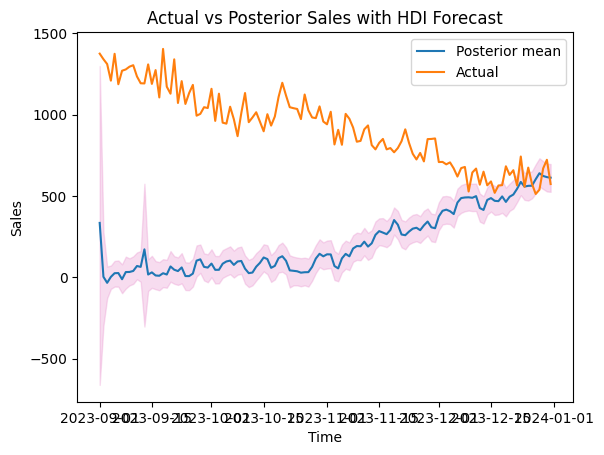

In [81]:
fig, ax = plt.subplots()
forecast_time=post_period_df.index
ax.plot(forecast_time, post_period_pred, label='Posterior mean')
ax.plot(post_period_df.index, post_period_df.Sales, label='Actual')
ax.fill_between(forecast_time, *hdi_forecast['obs'].values.T, alpha=0.25, color="tab:pink")
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax.set_title('Actual vs Posterior Sales with HDI Forecast')

Text(0.5, 1.0, 'Post-intervention causal impact')

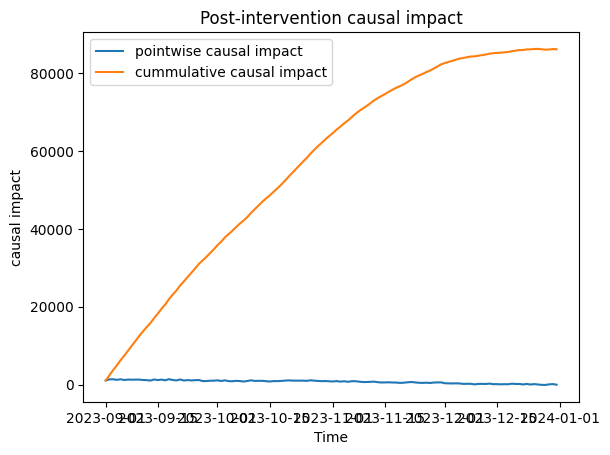

In [84]:
fig, ax = plt.subplots()
ax.plot(forecast_time,impact, label='pointwise causal impact')
ax.plot(forecast_time,impact_c, label='cummulative causal impact')
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('causal impact')
ax.set_title('Post-intervention causal impact')